In [173]:
# Импорт библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from sklearn.preprocessing import LabelEncoder
from statsmodels.stats.proportion import proportions_ztest

In [174]:
# Игнорирование предупреждений
warnings.filterwarnings("ignore")

In [2]:
# Отображение максимального количества столбцов в датафреймах
pd.set_option('display.max_columns', None)  

In [3]:
# Датафрейм с событиями
df_hits = pd.read_csv('data/ga_hits.csv', low_memory=False)
df_hits.head()

,session_id,hit_date,hit_time,hit_number,hit_type,hit_referer,hit_page_path,event_category,event_action,event_label,event_value
0,5639623078712724064.1640254056.1640254056,2021-12-23,597864.0,30,event,NaN,sberauto.com/cars?utm_source_initial=google&ut...,quiz,quiz_show,NaN,NaN
1,7750352294969115059.1640271109.1640271109,2021-12-23,597331.0,41,event,NaN,sberauto.com/cars/fiat?city=1&city=18&rental_c...,quiz,quiz_show,NaN,NaN
2,885342191847998240.1640235807.1640235807,2021-12-23,796252.0,49,event,NaN,sberauto.com/cars/all/volkswagen/polo/e994838f...,quiz,quiz_show,NaN,NaN
3,142526202120934167.1640211014.1640211014,2021-12-23,934292.0,46,event,NaN,sberauto.com/cars?utm_source_initial=yandex&ut...,quiz,quiz_show,NaN,NaN
4,3450086108837475701.1640265078.1640265078,2021-12-23,768741.0,79,event,NaN,sberauto.com/cars/all/mercedes-benz/cla-klasse...,quiz,quiz_show,NaN,NaN


In [4]:
# Размерность датафрейма
df_hits.shape

(15726470, 11)

In [5]:
# Информация о датафрейме
df_hits.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15726470 entries, 0 to 15726469
Data columns (total 11 columns):
 #   Column          Non-Null Count     Dtype  
---  ------          --------------     -----  
 0   session_id      15726470 non-null  object 
 1   hit_date        15726470 non-null  object 
 2   hit_time        6566148 non-null   float64
 3   hit_number      15726470 non-null  int64  
 4   hit_type        15726470 non-null  object 
 5   hit_referer     9451666 non-null   object 
 6   hit_page_path   15726470 non-null  object 
 7   event_category  15726470 non-null  object 
 8   event_action    15726470 non-null  object 
 9   event_label     11966286 non-null  object 
 10  event_value     0 non-null         float64
dtypes: float64(2), int64(1), object(8)
memory usage: 1.3+ GB


In [6]:
# Обзор значений столбцов
for col in df_hits.columns:
    print(df_hits[col].value_counts())

session_id
5442565791571325612.1632449195.1632449195    768
6568868914238486437.1632270313.1632270313    678
5959671972744778783.1632490527.1632490600    548
7452598043578978502.1632358598.1632358598    514
3070792010704358528.1629752408.1629752408    498
                                            ... 
4570994095441102117.1630324006.1630324006      1
768506153535315810.1630314342.1630314342       1
5517253735248338264.1630315080.1630315080      1
4054272189286640867.1630334209.1630334209      1
5381267721977892188.1640271196.1640271196      1
Name: count, Length: 1734610, dtype: int64
hit_date
2021-05-24    513035
2021-12-21    280192
2021-05-25    235805
2021-09-23    168899
2021-05-26    158382
               ...  
2021-07-24     23490
2021-05-23     18773
2021-05-19     14605
2021-05-22     13917
2021-05-21     13497
Name: count, Length: 226, dtype: int64
hit_time
0.0          41137
1.0          18522
2.0          10101
3.0           6060
4.0           4478
             ...  
54406

In [7]:
# Наличие дубликатов
df_hits.duplicated().sum()

0

In [8]:
# Пропущенные значения
missing_values = round(((df_hits.isna().sum() / len(df_hits)) * 100).sort_values(ascending=False), 2)

print('Процент пропущенных значений:')
missing_values

Процент пропущенных значений:


event_value       100.00
hit_time           58.25
hit_referer        39.90
event_label        23.91
session_id          0.00
hit_date            0.00
hit_number          0.00
hit_type            0.00
hit_page_path       0.00
event_category      0.00
event_action        0.00
dtype: float64

In [9]:
# Удалим все столбцы с пропусками, т.к. они > 20% всех записей, и hit_type, т.к. он константный
df_hits = df_hits.drop(['event_value', 'hit_time', 'hit_referer', 'event_label', 'hit_type'], axis=1)

In [10]:
# Типы данных признаков в датафрейме
df_hits.dtypes

session_id        object
hit_date          object
hit_number         int64
hit_page_path     object
event_category    object
event_action      object
dtype: object

In [11]:
# Изменение типа данных hit_date на тип datetime
df_hits.hit_date = pd.to_datetime(df_hits['hit_date'])

In [12]:
# Изменение типа данных hit_number на тип int32 для экономии памяти
df_hits.hit_number = df_hits['hit_number'].astype('int32')

In [13]:
# Изменение типа данных event_category и event_action на тип category
df_hits.event_category = df_hits['event_category'].astype('category')
df_hits.event_action = df_hits['event_action'].astype('category')

In [15]:
# Просмотр типов данных
df_hits.dtypes

session_id                object
hit_date          datetime64[ns]
hit_number                 int32
hit_page_path             object
event_category          category
event_action            category
dtype: object

In [16]:
# Создание новой колонки car_model
def find_auto(str):
    car_models = ['porsche', 'zotye', 'smart', 'honda', 'maserati', 'toyota', 'volvo', 'chrysler', 'suzuki', 'haval', 'foton',
                  'datsun', 'skoda', 'geely', 'uaz', 'buick', 'lada', 'dacia', 'lifan', 'lincoln', 'moskvich', 'jaguar', 'ford',
                  'rover', 'faw', 'scion', 'highlander', 'gaz', 'mercedes-benz', 'fiat', 'cheryexeed', 'dongfeng', 'chevrolet',
                  'rolls-royce', 'jac', 'opel', 'daewoo', 'bmw', 'mitsubishi', 'lexus', 'audi', 'vortex', 'byd', 'genesis',
                  'volkswagen', 'subaru', 'mazda', 'range-rover', 'seat', 'peugeot', 'ssangyong', 'jmc', 'gac', 'exeed', 'tesla',
                  'hummer', 'renault', 'chery', 'alfa-romeo', 'haima', 'nissan', 'mini', 'saab', 'hawtai', 'dodge', 'infiniti',
                  'zaz', 'cadillac', 'citroen', 'great wall', 'bentley', 'hyundai', 'baic', 'aurus', 'daihatsu', 'brilliance',
                  'land-rover', 'dw-hower', 'jeep', 'changan', 'kia']
    found_car_model = 'other'
    for car_model in car_models:
        if car_model in str: 
            found_car_model = car_model
    return found_car_model
df_hits['car_model'] = df_hits['hit_page_path'].apply(lambda x : find_auto(x))

In [19]:
# Создание новой колонки target_action со значениями target_action и not_target_action
df_hits['target_action'] = df_hits['event_action'].apply(lambda x: 'target_action' if x in ['sub_car_claim_click', 'sub_car_claim_submit_click', \
        'sub_open_dialog_click', 'sub_custom_question_submit_click', 'sub_call_number_click', 'sub_callback_submit_click', \
        'sub_submit_success', 'sub_car_request_submit_click'] else 'not_target_action')

In [20]:
df_hits.head()

,session_id,hit_date,hit_number,hit_page_path,event_category,event_action,car_model,target_action
0,5639623078712724064.1640254056.1640254056,2021-12-23,30,sberauto.com/cars?utm_source_initial=google&ut...,quiz,quiz_show,other,not_target_action
1,7750352294969115059.1640271109.1640271109,2021-12-23,41,sberauto.com/cars/fiat?city=1&city=18&rental_c...,quiz,quiz_show,fiat,not_target_action
2,885342191847998240.1640235807.1640235807,2021-12-23,49,sberauto.com/cars/all/volkswagen/polo/e994838f...,quiz,quiz_show,volkswagen,not_target_action
3,142526202120934167.1640211014.1640211014,2021-12-23,46,sberauto.com/cars?utm_source_initial=yandex&ut...,quiz,quiz_show,other,not_target_action
4,3450086108837475701.1640265078.1640265078,2021-12-23,79,sberauto.com/cars/all/mercedes-benz/cla-klasse...,quiz,quiz_show,mercedes-benz,not_target_action


In [21]:
# Типы данных колонок
df_hits.dtypes

session_id                object
hit_date          datetime64[ns]
hit_number                 int32
hit_page_path             object
event_category          category
event_action            category
car_model                 object
target_action             object
dtype: object

In [22]:
# Категориальные признаки для преобразования типа данных
categorical = ['car_model', 'target_action']

In [23]:
# Изменение типа колонок car_model и target_action на категориальный
df_hits[categorical] = df_hits[categorical].astype('category')

In [24]:
# Типы данных колонок
df_hits.dtypes

session_id                object
hit_date          datetime64[ns]
hit_number                 int32
hit_page_path             object
event_category          category
event_action            category
car_model               category
target_action           category
dtype: object

In [25]:
# Датафрейм с визитами на сайт
df_sessions = pd.read_csv('data/ga_sessions.csv', low_memory=False)
df_sessions.head()

,session_id,client_id,visit_date,visit_time,visit_number,utm_source,utm_medium,utm_campaign,utm_adcontent,utm_keyword,device_category,device_os,device_brand,device_model,device_screen_resolution,device_browser,geo_country,geo_city
0,9055434745589932991.1637753792.1637753792,2108382700.1637753791,2021-11-24,14:36:32,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,puhZPIYqKXeFPaUviSjo,mobile,Android,Huawei,NaN,360x720,Chrome,Russia,Zlatoust
1,905544597018549464.1636867290.1636867290,210838531.1636867288,2021-11-14,08:21:30,1,MvfHsxITijuriZxsqZqt,cpm,FTjNLDyTrXaWYgZymFkV,xhoenQgDQsgfEPYNPwKO,IGUCNvHlhfHpROGclCit,mobile,Android,Samsung,NaN,385x854,Samsung Internet,Russia,Moscow
2,9055446045651783499.1640648526.1640648526,2108385331.1640648523,2021-12-28,02:42:06,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,puhZPIYqKXeFPaUviSjo,mobile,Android,Huawei,NaN,360x720,Chrome,Russia,Krasnoyarsk
3,9055447046360770272.1622255328.1622255328,2108385564.1622255328,2021-05-29,05:00:00,1,kjsLglQLzykiRbcDiGcD,cpc,NaN,NOBKLgtuvqYWkXQHeYWM,NaN,mobile,NaN,Xiaomi,NaN,393x786,Chrome,Russia,Moscow
4,9055447046360770272.1622255345.1622255345,2108385564.1622255328,2021-05-29,05:00:00,2,kjsLglQLzykiRbcDiGcD,cpc,NaN,NaN,NaN,mobile,NaN,Xiaomi,NaN,393x786,Chrome,Russia,Moscow


In [26]:
# Размерность датафрейма
df_sessions.shape

(1860042, 18)

In [27]:
# Информация о датафрейме
df_sessions.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1860042 entries, 0 to 1860041
Data columns (total 18 columns):
 #   Column                    Non-Null Count    Dtype 
---  ------                    --------------    ----- 
 0   session_id                1860042 non-null  object
 1   client_id                 1860042 non-null  object
 2   visit_date                1860042 non-null  object
 3   visit_time                1860042 non-null  object
 4   visit_number              1860042 non-null  int64 
 5   utm_source                1859945 non-null  object
 6   utm_medium                1860042 non-null  object
 7   utm_campaign              1640439 non-null  object
 8   utm_adcontent             1524427 non-null  object
 9   utm_keyword               777981 non-null   object
 10  device_category           1860042 non-null  object
 11  device_os                 789904 non-null   object
 12  device_brand              1492864 non-null  object
 13  device_model              16338 non-null  

In [28]:
# Обзор значений столбцов
for col in df_sessions.columns:
    print(df_sessions[col].value_counts())

session_id
9055434745589932991.1637753792.1637753792    1
6294640354816492625.1638728787.1638728809    1
6294832296889291185.1623245519.1623245519    1
6294832296889291185.1623161065.1623161065    1
6294832296889291185.1623156608.1623156608    1
                                            ..
3525580570051063315.1625927189.1625927189    1
3525573324456022940.1640876964.1640876964    1
3525573324456022940.1640837067.1640837067    1
3525573324456022940.1640715164.1640715164    1
9055430416266113553.1640968742.1640968742    1
Name: count, Length: 1860042, dtype: int64
client_id
1750498477.1629450062    462
130918396.1628014141     334
1266574870.1623140118    309
736859557.1619557452     306
1894772482.1621860860    276
                        ... 
878941885.1625317311       1
878939941.1634822476       1
878939745.1621890533       1
878933864.1624201491       1
2108381692.1640968721      1
Name: count, Length: 1391719, dtype: int64
visit_date
2021-05-24    39453
2021-12-21    30704
2021-0

In [29]:
# Наличие дубликатов
df_sessions.duplicated().sum()

0

In [30]:
# Пропущенные значения
missing_values = round(((df_sessions.isna().sum() / len(df_sessions)) * 100).sort_values(ascending=False), 2)

print('Процент пропущенных значений:')
missing_values

Процент пропущенных значений:


device_model                99.12
utm_keyword                 58.17
device_os                   57.53
device_brand                19.74
utm_adcontent               18.04
utm_campaign                11.81
utm_source                   0.01
geo_country                  0.00
device_browser               0.00
device_screen_resolution     0.00
session_id                   0.00
device_category              0.00
client_id                    0.00
utm_medium                   0.00
visit_number                 0.00
visit_time                   0.00
visit_date                   0.00
geo_city                     0.00
dtype: float64

In [31]:
# Уникальные значения device_model
df_sessions.device_model.unique()

array([nan, 'qBRdfuuhOnnqwSqNiPOv', 'AshpvdJdReafUzEMmWGr',
       'AuMdmADEIoPXiWpTsBEj', 'pcvPxfVFaAmhwFmvIeYd',
       'mzJXHtJPIOSHoHtgezIA', 'pTgAEPipQxDXCjPrJbHo',
       'IiVVIXFnNMwpBtuHILvS', 'FJApgTrMAGHoxCxQVKws',
       'tfPZFRbtlzEssBEesRwM', 'tWBQlsvNfHxRUjaPAfhd',
       'cwMJxNXiWUgMUxGiCTPs', 'zFCiMWkbbAhTflrlLWnz',
       'phrsMxwuvNvYsPYNbKkL', 'QIRMJBHwssjlXzlheRfO',
       'CwplVZElsIzdKfSTHwma', 'auOrYtJwDXWlMwuBxhRC',
       'kGgpyeEtacYWhzbuuWMR', 'DzXtLnggNbQSyyFLKlgY',
       'HYwfQOXoovXynCsiUCVd', 'mSVMBvlHFgftJaQAZEdp',
       'kpwoWlshUwRtxMMtxukt', 'opEZzhCrCCxqjKDmOcMK',
       'FMeAKypVmqdjUhayrjne', 'lOMpyAuAISPFiAxjXIYM',
       'kjULrCjbRVbJtOfWpmQI', 'adBSYqsJPBFluBxhXRzx',
       'jXFxTkHxuiBKWOvUtsIa', 'BhXucgFEfQMgSWpyKikP',
       'ciZAODXEPQGDKvuEabGr', 'bwQQjmDtGgrbnrREsYSG',
       'JAIKWwxRffFOXQcfGTVi', 'XoFyyEyrxZQbFrIVBGJU',
       'oLPSmNOyoeTqtTUhnNIq', 'wsPZygnUifLMgkSEnWLj',
       'wOpkmMMUmanXnzWXmcFq', 'eZRFfVvdAEANFDdbkujh',
     

In [32]:
# Количество уникальных значений device_model
df_sessions.device_model.nunique()

104

In [33]:
# Заполнение пустых значений device_model значением other
df_sessions.device_model = df_sessions.device_model.fillna('other')

In [34]:
# Уникальные значения utm_keyword
df_sessions.utm_keyword.unique()

array(['puhZPIYqKXeFPaUviSjo', 'IGUCNvHlhfHpROGclCit', nan, ...,
       'aCaBoYaQJPVffhjBQnut', 'RaeBwzCLChMDgYYukNOw',
       'fcXWTQaKfxbkBkBnzLhK'], dtype=object)

In [35]:
# Количество уникальных значений utm_keyword
df_sessions.utm_keyword.nunique()

1219

In [36]:
# Заполнение пустых значений utm_keyword значением other
df_sessions.utm_keyword = df_sessions.utm_keyword.fillna('other')

In [37]:
# Уникальные значения device_os
df_sessions.device_os.unique()

array(['Android', nan, 'iOS', 'Windows', 'Linux', 'Macintosh',
       '(not set)', 'Chrome OS', 'BlackBerry', 'Tizen', 'Firefox OS',
       'Samsung', 'Windows Phone', 'Nokia'], dtype=object)

In [38]:
# Уникальные значения device_os и их количество
df_sessions.device_os.value_counts()

device_os
Android          464054
iOS              207104
Windows           88307
Macintosh         24824
Linux              5120
(not set)           364
Chrome OS            83
BlackBerry           27
Tizen                 7
Samsung               4
Windows Phone         4
Firefox OS            3
Nokia                 3
Name: count, dtype: int64

In [39]:
# Заполнение пустых значений device_os значением other
df_sessions.device_os = df_sessions.device_os.fillna('other')

In [40]:
# Удалим оставшиеся записи с пропущенными значениями
df_sessions = df_sessions.dropna()

In [41]:
# Создание новой колонки organic_traffic со значениями organic_traffic и paid_traffic
df_sessions['organic_paid_traffic'] = df_sessions['utm_medium'].apply(lambda x: 'organic_traffic' if x in [
    'organic', 'referral', '(none)'] else 'paid_traffic')

In [42]:
# Создание новой колонки social_media со значениями social_media и not_social_media
df_sessions['social_media'] = df_sessions['utm_source'].apply(lambda x: 'social_media' if x in ['QxAxdyPLuQMEcrdZWdWb', \
           'MvfHsxITijuriZxsqZqt', 'ISrKoXQCxqqYvAZICvjs', 'IZEXUFLARCUMynmHNBGo', 'PlbkrSYoHuZBWfYjYnfw', 'gVRrcxiDQubJiljoTbGm'] \
           else 'not_social_media')

In [43]:
# Создание новой колонки device_category_type со значениями mobile и desktop
df_sessions['device_category_type'] = df_sessions['device_category'].apply(lambda x : 'mobile' if x in ['mobile', 'tablet'] else 'desktop')

In [44]:
regions_presence = ['Saint Petersburg', 
                    'Moscow',
                    'Podolsk',
                    'Korolyov',
                    'Kolomna',
                    'Naro-Fominsk',
                    'Dzerzhinsky',
                    'Krasnogorsk',
                    'Balashikha',
                    'Dmitrov',
                    'Sergiyev Posad',
                    'Odintsovo',
                    'Lobnya',
                    'Yegoryevsk',
                    'Kotelniki',
                    'Mytishchi',
                    'Zheleznodorozhny',
                    'Serpukhov',
                    'Shchyolkovo',
                    'Vidnoye',
                    'Khimki',
                    'Golitsyno',
                    'Ramenskoye',
                    'Dubna',
                    'Likino-Dulyovo',
                    'Ivanteyevka',
                    'LesnoyGorodok',
                    'Istra',
                    'Losino-Petrovsky',
                    'SaintPetersburg',
                    'Elektrogorsk',
                    'Protvino',
                    'Klimovsk',
                    'Tomilino',
                    'Petrovo-Dalneye',
                    'Pushkino',
                    'Orekhovo-Zuyevo',
                    'Voskresensk',
                    'Fryazino',
                    'Kraskovo',
                    'Khotkovo',
                    'Kubinka',
                    'Chernogolovka',
                    'Dolgoprudny']
df_sessions['region_of_presence'] = df_sessions['geo_city'].apply(lambda x : 'regions_presence' if x in regions_presence else 'not_regions_presence')

In [45]:
# Типы данных столбцов df_sessions
df_sessions.dtypes

session_id                  object
client_id                   object
visit_date                  object
visit_time                  object
visit_number                 int64
utm_source                  object
utm_medium                  object
utm_campaign                object
utm_adcontent               object
utm_keyword                 object
device_category             object
device_os                   object
device_brand                object
device_model                object
device_screen_resolution    object
device_browser              object
geo_country                 object
geo_city                    object
organic_paid_traffic        object
social_media                object
device_category_type        object
region_of_presence          object
dtype: object

In [46]:
# Преобразование типа данных visit_number в int32 для экономии памяти
df_sessions['visit_number'] = df_sessions['visit_number'].astype('int32')

In [47]:
# Преобразование типа данных visit_date и visit_time в datetime64[ns]
df_sessions[['visit_date', 'visit_time']] = df_sessions[['visit_date', 'visit_time']].astype('datetime64[ns]')

In [48]:
# Категориальные переменные для преобразования типа данных
categorical = ['utm_medium', 'device_category', 'device_os', 'device_brand', 'device_model', 'device_screen_resolution', \
               'device_browser', 'geo_country', 'geo_city', 'organic_paid_traffic', 'social_media', 'device_category_type', \
               'region_of_presence']

In [49]:
# Преобразование типа данных в категориальный
df_sessions[categorical] = df_sessions[categorical].astype('category')

In [50]:
# Типы данных
df_sessions.dtypes

session_id                          object
client_id                           object
visit_date                  datetime64[ns]
visit_time                  datetime64[ns]
visit_number                         int32
utm_source                          object
utm_medium                        category
utm_campaign                        object
utm_adcontent                       object
utm_keyword                         object
device_category                   category
device_os                         category
device_brand                      category
device_model                      category
device_screen_resolution          category
device_browser                    category
geo_country                       category
geo_city                          category
organic_paid_traffic              category
social_media                      category
device_category_type              category
region_of_presence                category
dtype: object

In [51]:
# Размерность датафрейма df_hits
df_hits.shape

(15726470, 8)

In [52]:
# Размерность датафрейма df_sessions
df_sessions.shape

(1230859, 22)

In [53]:
# Объединение датафреймов в единый датасет
df = pd.merge(df_hits, df_sessions, on='session_id', how='inner')
df.head()

,session_id,hit_date,hit_number,hit_page_path,event_category,event_action,car_model,target_action,client_id,visit_date,visit_time,visit_number,utm_source,utm_medium,utm_campaign,utm_adcontent,utm_keyword,device_category,device_os,device_brand,device_model,device_screen_resolution,device_browser,geo_country,geo_city,organic_paid_traffic,social_media,device_category_type,region_of_presence
0,7750352294969115059.1640271109.1640271109,2021-12-23,41,sberauto.com/cars/fiat?city=1&city=18&rental_c...,quiz,quiz_show,fiat,not_target_action,1804519513.1640268211,2021-12-23,2025-08-15 17:51:49,2,ZpYIoDJMcFzVoPFsHGJL,banner,zxoiLxhuSIFrCeTLQVWZ,JNHcPlZPxEMWDnRiyoBf,puhZPIYqKXeFPaUviSjo,mobile,Android,Xiaomi,other,393x851,Chrome,Russia,Chelyabinsk,paid_traffic,not_social_media,mobile,not_regions_presence
1,281215510786615563.1640245516.1640245516,2021-12-23,102,sberauto.com/cars/toyota?isnew=false&rental_ca...,quiz,quiz_show,toyota,not_target_action,65475588.1640245515,2021-12-23,2025-08-15 10:45:16,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,puhZPIYqKXeFPaUviSjo,mobile,iOS,Apple,other,375x812,Safari,Russia,Vladivostok,paid_traffic,not_social_media,mobile,not_regions_presence
2,5636135307570360848.1640280592.1640280592,2021-12-23,3,sberauto.com/cars/all/renault/duster/145d53f1?...,card_web,view_card,renault,not_target_action,1312265011.1640280592,2021-12-23,2025-08-15 20:29:52,1,fDLlAcSmythWSCVMvqvL,(none),LTuZkdKfxRGVceoWkVyg,JNHcPlZPxEMWDnRiyoBf,puhZPIYqKXeFPaUviSjo,mobile,iOS,Apple,other,375x812,YaBrowser,Russia,Moscow,organic_traffic,not_social_media,mobile,regions_presence
3,951771360093549217.1640247969.1640247969,2021-12-23,3,client.saptest.sberauto-team.com/cars/all/merc...,card_web,view_card,mercedes-benz,not_target_action,221601538.1640247969,2021-12-23,2025-08-15 11:26:09,1,fDLlAcSmythWSCVMvqvL,(none),LTuZkdKfxRGVceoWkVyg,JNHcPlZPxEMWDnRiyoBf,puhZPIYqKXeFPaUviSjo,mobile,iOS,Apple,other,428x926,Chrome,Russia,Korolyov,organic_traffic,not_social_media,mobile,regions_presence
4,8052362820286977556.1640273512.1640273512,2021-12-23,5,sberauto.com/cars/all/bmw/5-serii/eb5698f6?utm...,card_web,view_card,bmw,not_target_action,1874836818.1640273428,2021-12-23,2025-08-15 18:31:52,2,IZEXUFLARCUMynmHNBGo,blogger_channel,foFTSdUvNqqkPzZvgiqt,DZYjhfIUfdqhfuTNUmjn,puhZPIYqKXeFPaUviSjo,mobile,Android,Samsung,other,412x915,Chrome,Russia,Voronezh,paid_traffic,social_media,mobile,not_regions_presence


In [54]:
# Размерность датасета
df.shape

(9765584, 29)

In [55]:
# Пропущенные значения
df.isna().sum().sort_values()

session_id                  0
social_media                0
organic_paid_traffic        0
geo_city                    0
geo_country                 0
device_browser              0
device_screen_resolution    0
device_model                0
device_brand                0
device_os                   0
device_category             0
utm_keyword                 0
utm_adcontent               0
device_category_type        0
utm_campaign                0
utm_source                  0
visit_number                0
visit_time                  0
visit_date                  0
client_id                   0
target_action               0
car_model                   0
event_action                0
event_category              0
hit_page_path               0
hit_number                  0
hit_date                    0
utm_medium                  0
region_of_presence          0
dtype: int64

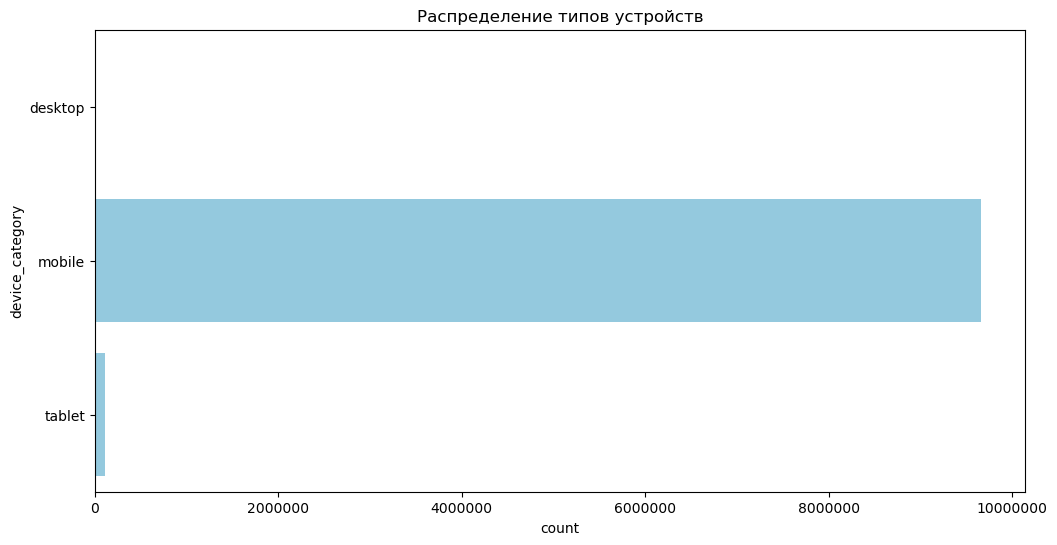

In [156]:
# Распределение типов устройств
plt.figure(figsize=(12, 6))
plt.ticklabel_format(style='plain')
sns.countplot(df['device_category'], color='skyblue')
plt.title('Распределение типов устройств')
plt.show()

Мобильные устройства преобладают среди остальных у пользователей сервиса.

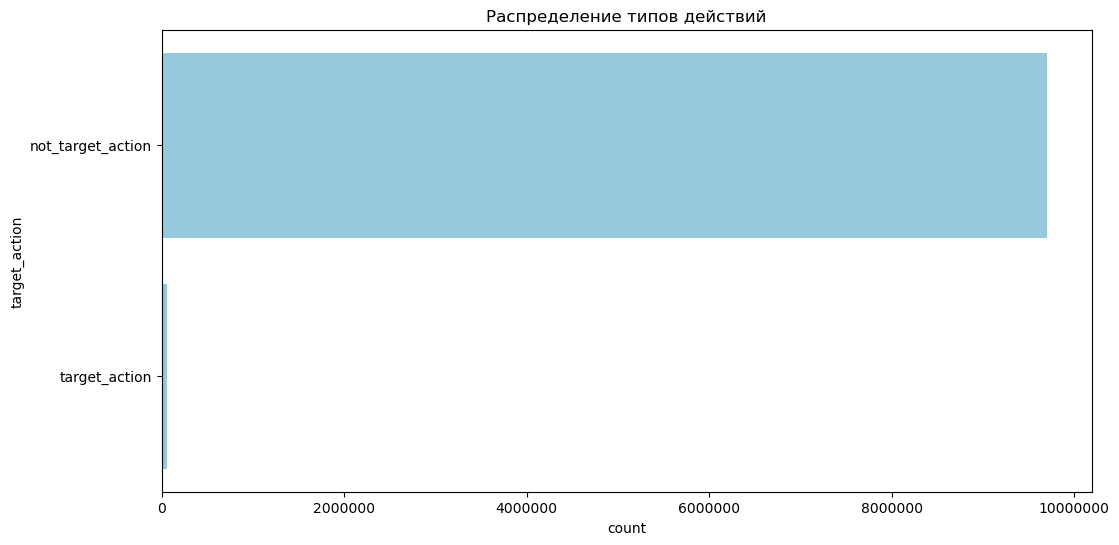

In [107]:
# Распределение типов действий
plt.figure(figsize=(12, 6))
plt.ticklabel_format(style='plain')
sns.countplot(df['target_action'], color='skyblue')
plt.title('Распределение типов действий')
plt.show()

Доля нецелевых действий преобладает над долей целевых действий.

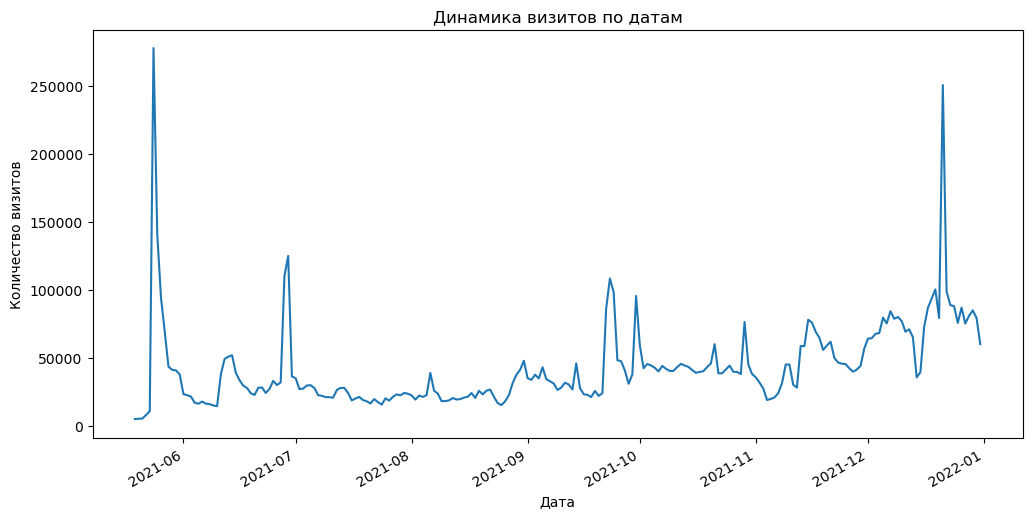

In [103]:
# Визуализация визитов по датам
plt.figure(figsize=(12, 6))
df.groupby('visit_date').size().plot()
plt.title('Динамика визитов по датам')
plt.xlabel('Дата')
plt.ylabel('Количество визитов')
plt.show()

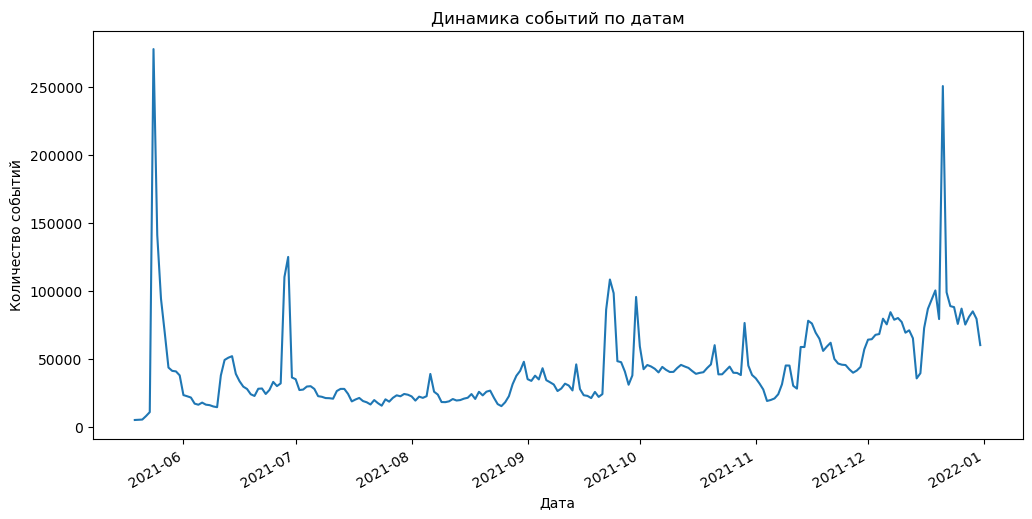

In [104]:
# Визуализация событий по датам
plt.figure(figsize=(12, 6))
df.groupby('hit_date').size().plot()
plt.title('Динамика событий по датам')
plt.xlabel('Дата')
plt.ylabel('Количество событий')
plt.show()

Графики визитов и событий по датам идентичны. Всплеск пользовательской активности наблюдается в июне 2021 года и в январе 2022 года.

Проверим некоторые гипотезы.

H0: Органический трафик не отличается от платного с точки зрения CR (Conversion Rate) в целевые события.

H1: CR органического и платного трафика различны.

In [57]:
df.groupby(['organic_paid_traffic','target_action'], observed=False)['session_id'].count()

organic_paid_traffic  target_action    
organic_traffic       not_target_action    3320388
                      target_action          23720
paid_traffic          not_target_action    6381988
                      target_action          39488
Name: session_id, dtype: int64

In [58]:
df_cr_traffic = pd.pivot_table(
    df, values='session_id', index='organic_paid_traffic', columns=['target_action'], aggfunc="count", observed=False).reset_index()
df_cr_traffic['cr'] = df_cr_traffic['target_action'] * 100 / (df_cr_traffic['not_target_action'] + df_cr_traffic['target_action'])
df_cr_traffic.sort_values(by='cr', ascending=False).head(10)

target_action,organic_paid_traffic,not_target_action,target_action,cr
0,organic_traffic,3320388,23720,0.709307
1,paid_traffic,6381988,39488,0.614937


In [59]:
counts = np.array(df_cr_traffic['target_action'])
nobs = np.array(df_cr_traffic['not_target_action'] + df_cr_traffic['target_action'])
stat, pval = proportions_ztest(counts, nobs)
print(f"Z = {stat:.3f}, p = {pval:.4f}")

Z = 17.451, p = 0.0000


На уровне значимости 0.01 нулевая гипотеза отвергается и принимается альтернативная гипотеза.

Conversion Rate органического и платного трафика различны.

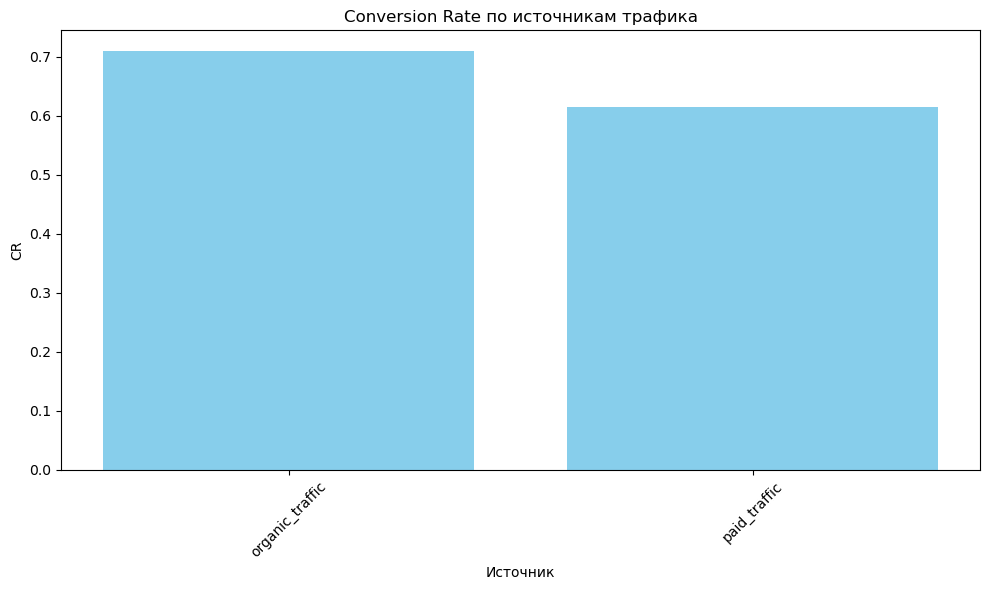

In [100]:
plt.figure(figsize=(10, 6))
plt.bar(df_cr_traffic['organic_paid_traffic'], df_cr_traffic['cr'], color='skyblue')
plt.title('Conversion Rate по источникам трафика')
plt.ylabel('CR')
plt.xlabel('Источник')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

H0: Трафик с мобильных устройств не отличается от трафика с десктопных устройств с точки зрения CR в целевые события.

H1: CR мобильного и десктопного трафика различны.

In [60]:
df.groupby(['device_category_type','target_action'], observed=False)['session_id'].count()

device_category_type  target_action    
desktop               not_target_action        287
                      target_action              0
mobile                not_target_action    9702089
                      target_action          63208
Name: session_id, dtype: int64

In [61]:
df_cr_device = pd.pivot_table(
    df, values='session_id', index='device_category_type', columns=['target_action'], aggfunc="count", observed=False).reset_index()
df_cr_device['cr'] = df_cr_device['target_action'] * 100 / (df_cr_device['not_target_action'] + df_cr_device['target_action'])
df_cr_device.sort_values(by='cr', ascending=False).head(10)

target_action,device_category_type,not_target_action,target_action,cr
1,mobile,9702089,63208,0.647272
0,desktop,287,0,0.000000


In [62]:
counts = np.array(df_cr_device['target_action'])
nobs = np.array(df_cr_device['not_target_action'] + df_cr_device['target_action'])
stat, pval = proportions_ztest(counts, nobs)
print(f"Z = {stat:.3f}, p = {pval:.4f}")

Z = -1.367, p = 0.1715


На уровне значимости 0.01 нулевая гипотеза не может быть отвергнута.

Разница между Conversion Rate мобильного и десктопного трафика статистически не значима.

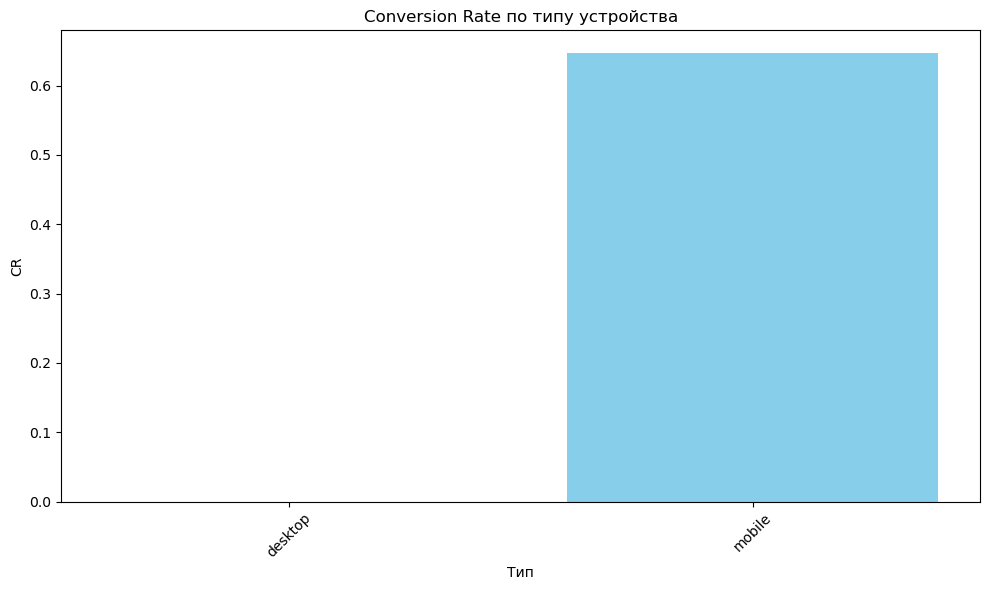

In [116]:
plt.figure(figsize=(10, 6))
plt.bar(df_cr_device['device_category_type'], df_cr_device['cr'], color='skyblue')
plt.title('Conversion Rate по типу устройства')
plt.ylabel('CR')
plt.xlabel('Тип')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

H0: Трафик из городов присутствия (Москва и область, Санкт-Петербург) не отличается от трафика из иных регионов с точки зрения CR в целевые события.

H1: CR трафика из городов присутствия и остальных городов различны.

In [63]:
df.groupby(['region_of_presence', 'target_action'], observed=False)['session_id'].count()

region_of_presence    target_action    
not_regions_presence  not_target_action    4236901
                      target_action          24494
regions_presence      not_target_action    5465475
                      target_action          38714
Name: session_id, dtype: int64

In [64]:
df_cr_regions = pd.pivot_table(
    df, values='session_id', index='region_of_presence', columns=['target_action'], aggfunc="count", observed=False).reset_index()
df_cr_regions['cr'] = df_cr_regions['target_action'] * 100 / (df_cr_regions['not_target_action'] + df_cr_regions['target_action'])
df_cr_regions.sort_values(by='cr', ascending=False).head(10)

target_action,region_of_presence,not_target_action,target_action,cr
1,regions_presence,5465475,38714,0.703355
0,not_regions_presence,4236901,24494,0.574788


In [65]:
counts = np.array(df_cr_regions['target_action'])
nobs = np.array(df_cr_regions['not_target_action'] + df_cr_regions['target_action'])
stat, pval = proportions_ztest(counts, nobs)
print(f"Z = {stat:.3f}, p = {pval:.4f}")

Z = -24.847, p = 0.0000


На уровне значимости 0.01 нулевая гипотеза отвергается и принимается альтернативная гипотеза.

Conversion Rate трафика из городов присутствия и остальных городов различны.

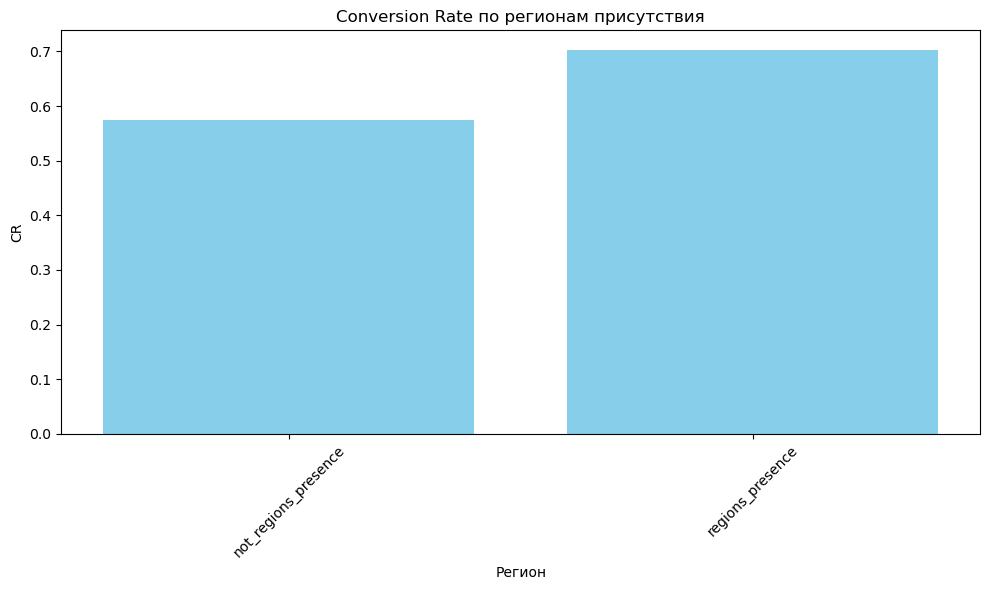

In [115]:
plt.figure(figsize=(10, 6))
plt.bar(df_cr_regions['region_of_presence'], df_cr_regions['cr'], color='skyblue')
plt.title('Conversion Rate по регионам присутствия')
plt.ylabel('CR')
plt.xlabel('Регион')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [66]:
# Из каких источников / кампаний / устройств / локаций к нам идёт самый целевой трафик (и с точки зрения объёма трафика, и с точки зрения CR)?
df.groupby(['target_action', 'organic_paid_traffic', 'device_category_type' ,'region_of_presence'], observed=False)['session_id'].count(
    ).reset_index().sort_values(by=['target_action', 'session_id'], ascending=False)

,target_action,organic_paid_traffic,device_category_type,region_of_presence,session_id
15,target_action,paid_traffic,mobile,regions_presence,23120
14,target_action,paid_traffic,mobile,not_regions_presence,16368
11,target_action,organic_traffic,mobile,regions_presence,15594
10,target_action,organic_traffic,mobile,not_regions_presence,8126
8,target_action,organic_traffic,desktop,not_regions_presence,0
9,target_action,organic_traffic,desktop,regions_presence,0
12,target_action,paid_traffic,desktop,not_regions_presence,0
13,target_action,paid_traffic,desktop,regions_presence,0
7,not_target_action,paid_traffic,mobile,regions_presence,3280713
6,not_target_action,paid_traffic,mobile,not_regions_presence,3101024


Самый целевой трафик поступает с мобильных устройств регионов присутствия по платному трафику.

In [114]:
# Какие авто пользуются наибольшим спросом?
df_demand_avto = pd.pivot_table(df, values='session_id', index=['target_action', 'car_model'], aggfunc="count", observed=False).reset_index(
    ).sort_values(by=['target_action', 'session_id'], ascending=False)
df_demand_avto.head(11)

,target_action,car_model,session_id
132,target_action,other,43896
142,target_action,skoda,5039
120,target_action,lada,3534
150,target_action,volkswagen,3135
119,target_action,kia,1871
127,target_action,mercedes-benz,1286
148,target_action,toyota,1220
136,target_action,renault,827
130,target_action,nissan,792
81,target_action,bmw,395


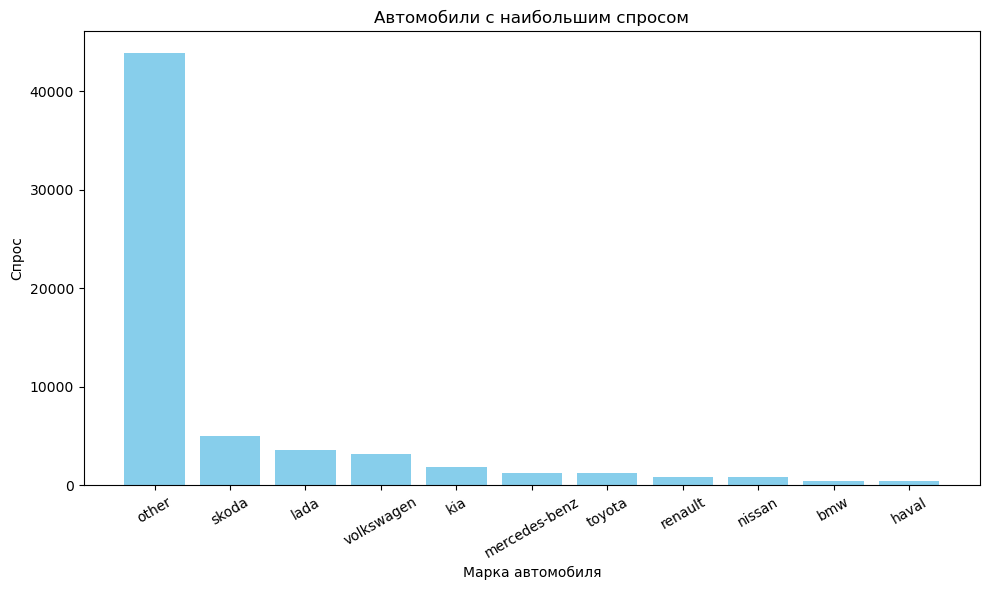

In [121]:
plt.figure(figsize=(10, 6))
plt.bar(df_demand_avto['car_model'].head(11), df_demand_avto['session_id'].head(11), color='skyblue')
plt.title('Автомобили с наибольшим спросом')
plt.ylabel('Спрос')
plt.xlabel('Марка автомобиля')
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()

In [113]:
print(f'Самые востребованные автомобили: {list(df_demand_avto['car_model'].values)}')

Самые востребованные автомобили: ['other', 'skoda', 'lada', 'volkswagen', 'kia', 'mercedes-benz', 'toyota', 'renault', 'nissan', 'bmw', 'haval']


In [123]:
# У каких авто самый лучший показатель CR (Conversion Rate) в целевые события?
df_cr_avto = pd.pivot_table(df, values='session_id', index='car_model', columns=['target_action'], aggfunc="count", observed=False).reset_index()
df_cr_avto['cr'] = df_cr_avto['target_action'] * 100 / (df_cr_avto['not_target_action'] + df_cr_avto['target_action'])
df_cr_avto = df_cr_avto.sort_values(by='cr', ascending=False)
df_cr_avto.head(10)

target_action,car_model,not_target_action,target_action,cr
32,hawtai,0,2,100.000000
70,tesla,51,2,3.773585
36,hyundai,9083,204,2.196619
66,smart,231,5,2.118644
23,fiat,53,1,1.851852
43,lada,225617,3534,1.542215
42,kia,124377,1871,1.482004
73,volkswagen,225378,3135,1.371913
71,toyota,87996,1220,1.367468
31,haval,31324,389,1.226626


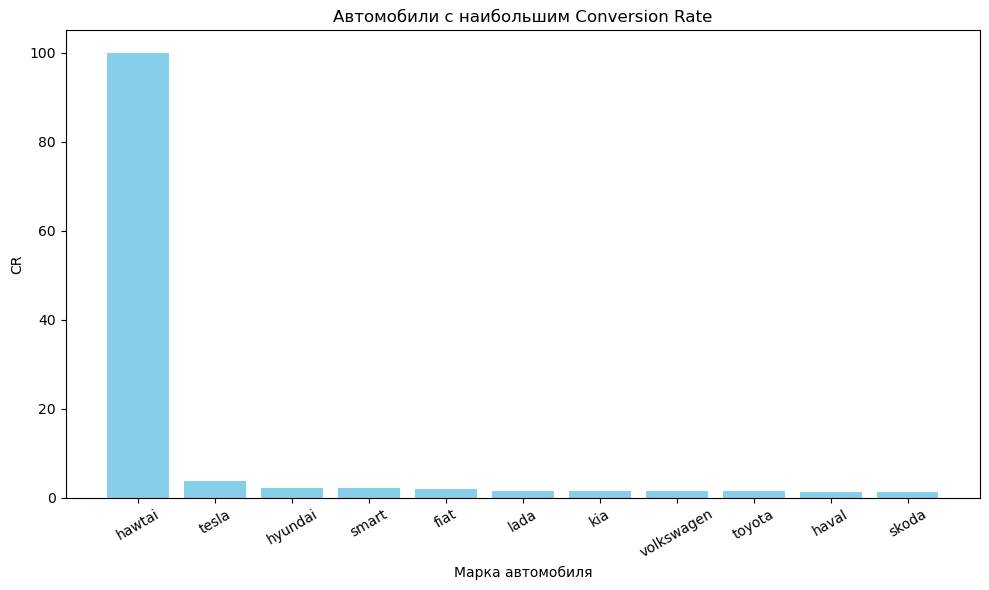

In [126]:
plt.figure(figsize=(10, 6))
plt.bar(df_cr_avto['car_model'].head(11), df_cr_avto['cr'].head(11), color='skyblue')
plt.title('Автомобили с наибольшим Conversion Rate')
plt.ylabel('CR')
plt.xlabel('Марка автомобиля')
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()

Самый лучший показатель CR в целевые события у автомобиля hawtai.

In [69]:
# Стоит ли нам увеличивать своё присутствие в соцсетях и давать там больше рекламы?
df_cr_social_media = pd.pivot_table(
    df, values='session_id', index='social_media', columns=['target_action'], aggfunc="count", observed=False).reset_index()
df_cr_social_media['cr'] = df_cr_social_media['target_action'] * 100 / (df_cr_social_media['not_target_action'] + df_cr_social_media['target_action'])
df_cr_social_media.sort_values(by='cr', ascending=False).head(10)

target_action,social_media,not_target_action,target_action,cr
1,social_media,514889,4733,0.910854
0,not_social_media,9187487,58475,0.632438


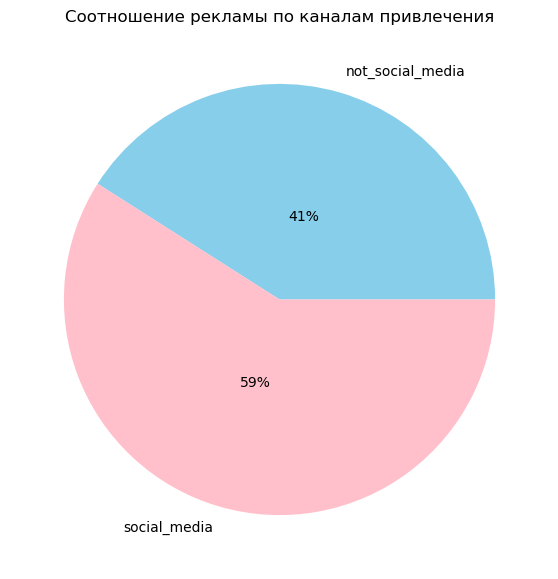

In [155]:
plt.figure(figsize=(7, 7))
plt.pie(
    df_cr_social_media['cr'],
    labels=df_cr_social_media['social_media'],
    autopct='%.0f%%',
    pctdistance=0.4,
    colors=['skyblue', 'pink']
)
plt.title('Соотношение рекламы по каналам привлечения')
plt.show()

Стоит покупать рекламу в соцсетях, т.к. конверсия в целевые действия там выше, чем на всех остальных каналах привлечения в сумме.